# Milestone 2

This notebook contains P2

In [8]:
import sys
import os
import os.path as op
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import gzip
import warnings
from tqdm.notebook import tqdm

import torch
from transformers import pipeline
from classify import classify

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

from utils import random_sample_from_csv_files, clean_data
from config import purpose_labels, level_labels, content_labels, DRIVE_PATH_VIVA, DRIVE_PATH_FLORIAN
from topic_filtering import *
from time_series import *
from visualisation import *

sys.path.insert(0, '.') # to use relative paths
path_data = op.join('data', 'raw')
path_deriv = op.join(path_data, '..', 'derivatives')
path_exploration_fig = os.path.join('data', 'figures', 'exploration')
path_edu = op.join(path_deriv, "Education_videos_{}.csv")

RAW_DATA_PATH = op.join(path_data, "yt_metadata_en.jsonl.gz") # change here to your data path !!!
warnings.filterwarnings("ignore")

In [ ]:
# TODO delete dans le final 
%load_ext autoreload
%autoreload 2

## Data Extraction

In [5]:
# The proper extraction
category = 'Education'
video_file_path = os.path.join(RAW_DATA_PATH, f'extracted_{category}', 'yt_metadata_en.jsonl.gz')
save_path = os.path.join(path_deriv) # change so you save it wherever you like

total_len = 3795564 # 3'795'564 (info obtained from metadata_subcategories.ipynb)
approx_length = round(total_len/1000000,1)*1000000 
N_BATCHES = 8
batch_size = int(np.floor_divide(approx_length,N_BATCHES)) # for 8 batches should end up with 475'000

#filter_jsonl(video_file_path, category, batch_size, save_path, verbose=True) # lengthy process do not call

## BART exploration

In [ ]:
# TODO Code de Florian a modifier eventuellement 
from utils import load_metadata_videos, bart_classification, plot_scores_BART
file_path = path_edu.format(5) # DRIVE_PATH_FLORIAN
df_education = load_metadata_videos(file_path)

In [ ]:
from config import purpose_labels, level_labels, content_labels

sample_row = 364772
title = df_education.loc[sample_row, 'title']
tags = df_education.loc[sample_row, 'tags']
combined_text = f"{title} {tags.replace(',', ', ')}"
print('Row:', sample_row)
print('Title:', title)
print('Tags:', tags)
purpose = bart_classification(combined_text, purpose_labels, multi_label=True, plot=True, title=title)
print("--> Purpose:", purpose)
level = bart_classification(combined_text, level_labels, multi_label=False, plot=True, title=title)
print("--> Level:  ", level)
content = bart_classification(combined_text, content_labels, multi_label=True, plot=True, title=title)
print("--> Content:", content)

## BERT and BART pipelines for assigning education subcategories

### Bert

In [ ]:
# Determine which gpu to use
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else :
    device = torch.device('cpu')

classifier = pipeline("zero-shot-classification", model="typeform/distilbert-base-uncased-mnli", device=device)

for i in range(N_BATCHES):
    data = pd.read_csv(op.join(path_deriv, f'Education_videos_{i}.csv'))
    clean_data = clean_data(data)
    # join information to use with the model
    clean_data['text'] = clean_data['title'] + clean_data['tags']

    final_data = classify(data, candidate_labels=purpose_labels, on='text', classifier=classifier, batch_size=32, multi_label=True)
    final_data.to_csv(op.join(path_deriv, f'Education_videos_{i}_classified_bert.csv'), index=False)

### Bart

In [ ]:
# Determine which gpu to use
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else :
    device = torch.device('cpu')
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

for i in range(N_BATCHES):
    data = pd.read_csv(op.join(path_deriv, f'Education_videos_{i}.csv'))
    clean_data = clean_data(data)
    # join information to use with the model
    clean_data['text'] = clean_data['title'] + clean_data['tags']

    final_data = classify(data, candidate_labels=purpose_labels, on='text', classifier=classifier, batch_size=32, multi_label=True)
    final_data.to_csv(op.join(path_deriv, f'Education_videos_{i}_classified_bart.csv'), index=False)

# Country extraction from YouTube Data API v3

In [ ]:
from utils import extract_channels_edu

channels = extract_channels_edu(path_edu, N_BATCHES, verbose = True)

Processing file : path_edu_0  --> Found 3412 channels
Processing file : path_edu_1  --> Found 3039 channels
Processing file : path_edu_2  --> Found 3069 channels
Processing file : path_edu_3  --> Found 3036 channels
Processing file : path_edu_4  --> Found 3384 channels
Processing file : path_edu_5  --> Found 3282 channels
Processing file : path_edu_6  --> Found 3150 channels
Processing file : path_edu_7  --> Found 3224 channels
Total number of channels : 25587


In [ ]:
from utils import youtube_country_scraper

countries = pd.DataFrame(columns = ['channel_id', 'country']) 
countries['channel_id'] = channels
countries['country'] = 'empty'

start = 0
end = len(countries) # max 10k per day - improved since now we do batches so can run all of them in one go
batch_size = 50 # max youtube allows per request

try:
    for i in tqdm(range(start,end,batch_size), total = (end - start)//batch_size, desc = 'Country extraction'):
        chs = channels[i:min(i+batch_size,end)]
        nations = youtube_country_scraper(chs, verbose= False)
        
        for ch in chs:
            countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
            tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

    if end % batch_size != 0:
        chs_extra = channels[(end//batch_size)* batch_size:end]
        nations = youtube_country_scraper(chs_extra, verbose= False)
        for i, ch in enumerate(chs_extra):
            countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
            tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

except HttpError as e:
        if e.resp.status == 403:
            print('Quota exceeded, saving extracted countries')
            countries.to_csv(op.join(path_deriv, 'countries.csv'), index = False)        

countries.to_csv(op.join(path_deriv, 'countries.csv'))
tqdm.write('Done!                                        ')

In [ ]:
# Redo the ones that could not be identified in the response to the api request - most of them are deleted channels
countries_redo = countries[countries.country == 'deleted'].reset_index(drop = True) 
for i, ch in tqdm(enumerate(countries_redo.channel_id), total = len(countries_redo)//10, desc = 'Countries redo'):
    nations = youtube_country_scraper([ch], verbose= False)
    countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
    tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

countries.to_csv(op.join(path_deriv, 'countries.csv'))

In [15]:
# Run from here on extracted data
countries = pd.read_csv(op.join(path_deriv, 'countries.csv'))

In [16]:
#group in single category all the countries with less than 10 channels
from utils import agglomerate_countries

filter = 20
countries_plt = countries.copy()
countries_plt['country'] = countries_plt['country'].apply(agglomerate_countries, args=(countries_plt['country'].value_counts(),filter))

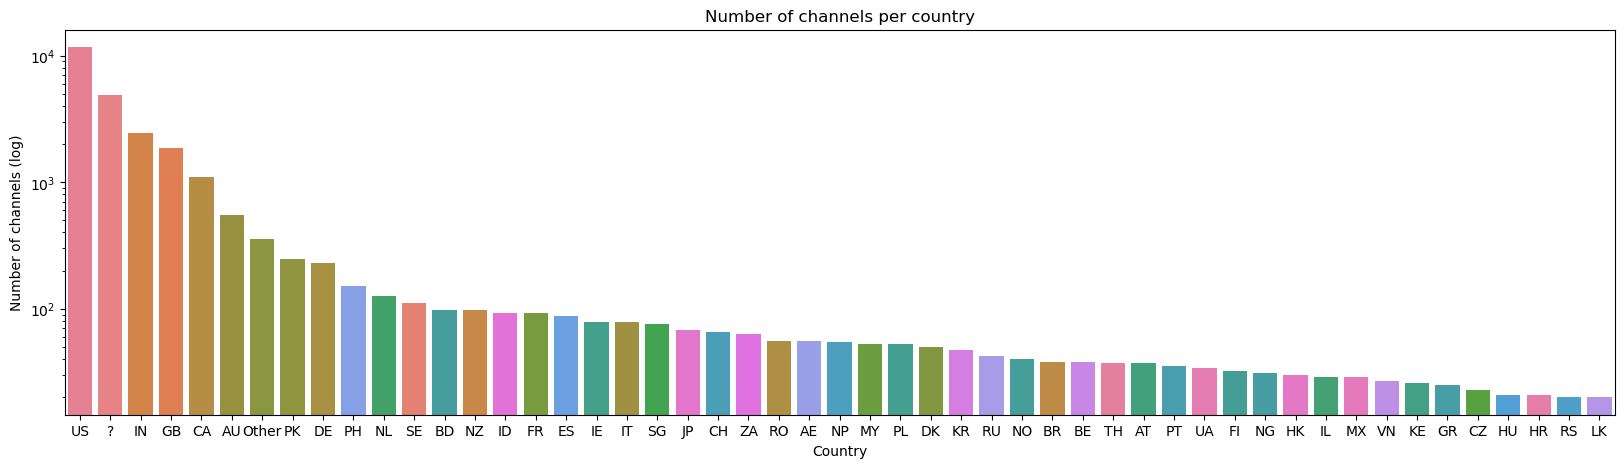

In [17]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(x='country', data=countries_plt, order = countries_plt['country'].value_counts(dropna=False).index, hue = 'country', ax=ax)
ax.set_yscale('log')
ax.set_title('Number of channels per country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of channels (log)')
plt.show()
# ax.legend_.remove()

### Preliminary analysis: Time series exploration

Plotting the new content creation duration about a certain topic between different categories. Compared to major events in the time period related to the topic. Plotting cross correlation between time series of different categories for one topic. 

In [ ]:
df_vd_sampled = pd.DataFrame()
# merge all the dataframes to df_vd_sampled
for i in range(N_BATCHES):
    df_vd = pd.read_csv(op.join(path_deriv, path_edu.format(i)))
    df_vd_sampled = pd.concat([df_vd_sampled, df_vd], ignore_index=True)    

# convention: 0 stands for all batches
sample_size = 0

with open(op.join(path_data,"events.json"), "r") as file:
    events = json.load(file)

frequencies = ["ME", "W"]

for freq in frequencies:
    for topic, data in events.items():
        url = data['url']
        events_dict = data['events']
        text = extract_text_from_wikipedia(url)
        keywords = find_keywords(text)

        weights = {'title': 2, 'description': 0.5, 'tags': 1}
        mask = df_vd_sampled.apply(lambda row: meets_keyword_requirements(row, keywords, weights), axis=1)
        df_vd_filtered = df_vd_sampled[mask]

        df_ts_s = create_time_slots(df_vd_filtered, freq)
        plot_time_series(df_ts_s,topic,sample_size, freq, events_dict)
        plot_cross_correlation(df_ts_s, topic, sample_size)

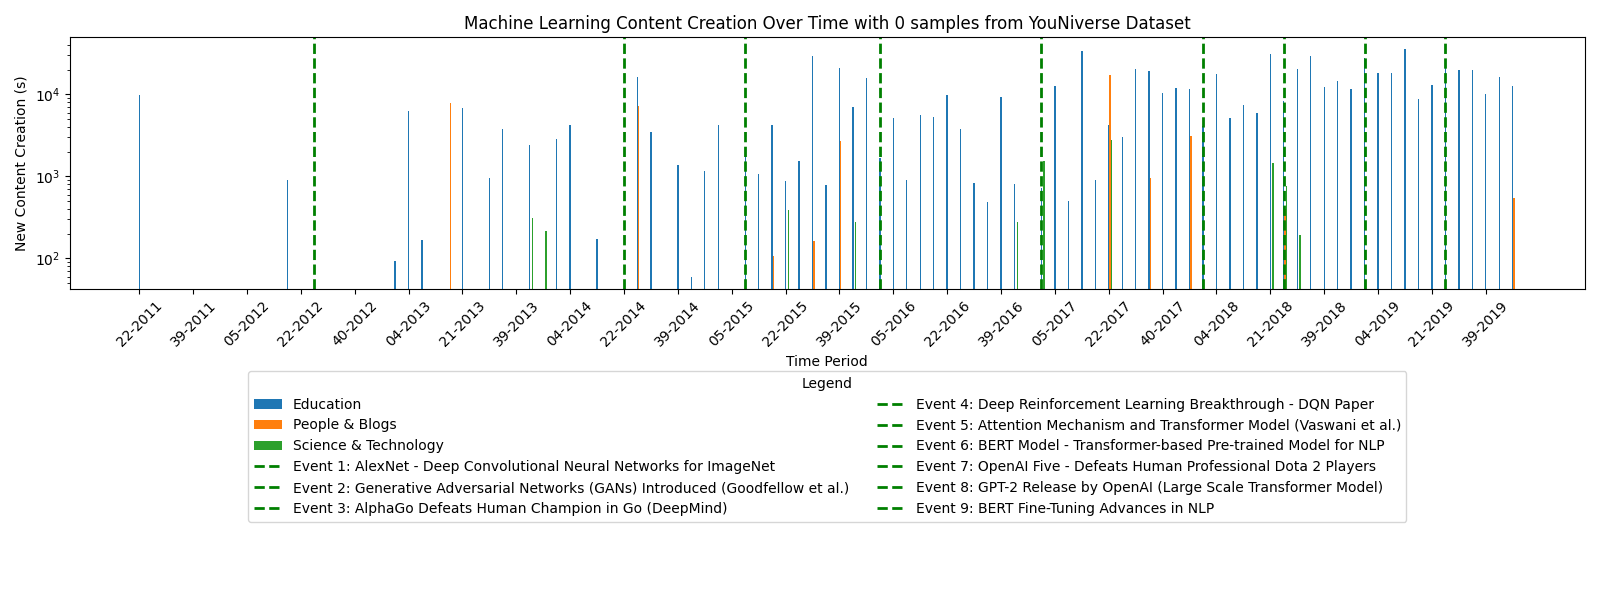

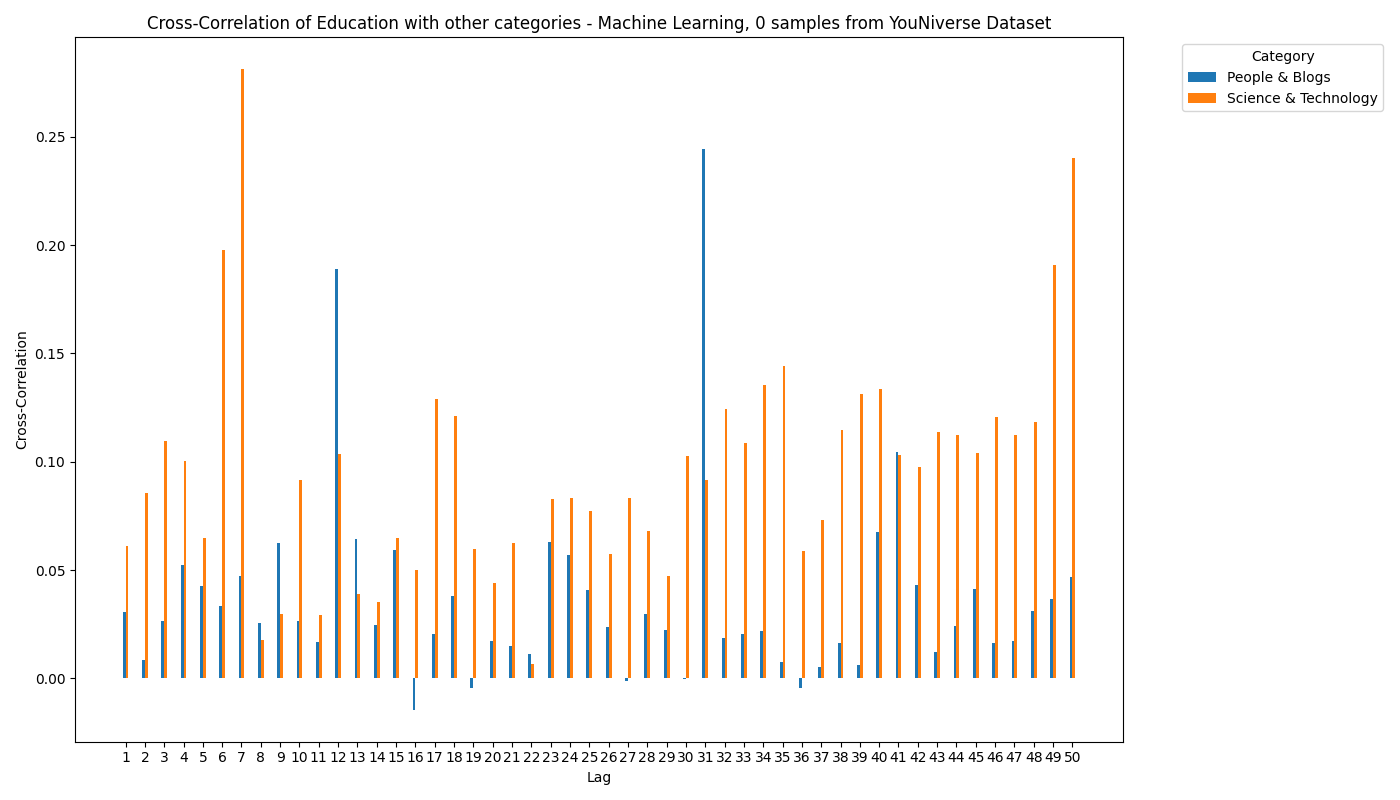